# Shape Free Reconstruction via Style Transfer Loss
## to Reconstruct Generated Image to get near the Ground truth ?

## ###############################################*100

# Prcoedure 
## Build Model
## Trainig in Batch
While Training:
    Pick Mask  image 
    Looping for n_iteration
        Pick batch_size images.
        Generate Images (# = batch_size
        Create Training Data 
        
        fit in NN to traing for 50 times 

End While till converge 




In [1]:
import numpy as np
import tensorflow as tf
#from tensorflow import keras
from keras import Model

import matplotlib.pyplot as plt
import cv2
from random import randint
import subprocess

from keras.layers import Input,Conv2D,Subtract, Lambda
%matplotlib inline
from keras.models import load_model
import os
import keras.backend as K
import random
from random import randint
from shape_free_conv import build_model # model definition and build is here



Using TensorFlow backend.


# Build Model (4 layer fully convolution CNN)

## Will Change LOss structure..layer near out put should have larger loss .
## should have style loss (layer 1-4), content loss(layer4), reconstruction loss (output layer)
current: for  layer 1-4 , should use gram_ matrix as style loss, but bugs happen...use MSE instead

In [2]:


def create_label(batch_size,ch,H,W,y,n_layer=5):
    label = []
    for i in range (1,n_layer):
        label.append(np.zeros(shape=[batch_size,ch*i,ch*i]))
    label.append (np.zeros(shape=[batch_size,3,3]))
    label.append (y)
    return label


# crete label with ALL Zero's fo rlater fit usage
# The label list depends on batch_sie, channel, Height, width, and layer size
def create_label(batch_size,ch,H,W,n_layer=5):
    label = []
    for i in range (1,n_layer):
        label.append(np.zeros(shape=[batch_size,ch*i,ch*i]))
    label.append (np.zeros(shape=[batch_size,H,W,3]))
    return label

# Train 
## 1 mask to fit  many True Images (According to batch_size)
## Procedure: 
## Chosse 1 Mask 
## Choose 8 images
## Gerenate 8 images 
## Generate 8 batch data

In [3]:

def generate_mask_list():

    # genreate mask, Note, for each image we will genreate 5 masks

    mask_list = [] # will genreate lts of masks and stored in mask_list

    num_mask = 10000


    for i in range(num_mask):

        x,y = np.random.randint(-30,30,size=2) # random 選取mask start point , x,y = 左上角座標
        w,h = np.random.randint(60,128,size=2) # ensure maks area 不會小於 50  也不會大於128
        mask_list.append((x,y,w,h))

    return mask_list

In [4]:
def generate_same_size_mask():
    # genreate mask, Note, for each image we will genreate 5 masks

    mask_list = [] # will genreate lts of masks and stored in mask_list

    num_mask = 10000
    w,h = np.random.randint(50,128,size=2) # ensure maks area 不會小於 50  也不會大於128

    for i in range(num_mask):

        x,y = np.random.randint(-30,30,size=2) # random 選取mask start point , x,y = 左上角座標
        
        mask_list.append((x,y,w,h))
    return mask_list


In [5]:

def choose_mask(mask_list):

    mask = np.zeros((256,256,3)).astype('uint8')

    choose = randint(0,9999)
    area = mask_list[choose]
    x,y,w,h = area
    print (x,y,w,h)
    #mask[x:x+w,y:y+h,:]=255
    mask[x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]=255  # masked area = 1
    plt.imshow(mask)
    return area, mask


In [6]:

# 1 mask for many images 

def generate_train_img(mask,area, src,ep,bacth_size, low=1,high=890):

    x,y,w,h =area
    true_img_batch = []
    masked_img_batch = []
    output_img_batch = []

    cv2.imwrite(src+'mask'+str(ep)+'.png', mask)
    mask_path = src+'mask'+str(ep)+'.png'


    pick_list = random.sample(range(low, high), batch_size)  # pick an image from 1 to 895
    for pick in pick_list:
        true_img_path =  src+'masked_img' +str(pick) + '.jpg'
        true_img = cv2.imread(src+str(pick)+'.jpg')
        true_img_batch.append  (true_img)
        plt.imshow(cv2.cvtColor(true_img, cv2.COLOR_BGR2RGB))

        masked_img = true_img.copy()
        masked_img[mask > 0] = 255
        cv2.imwrite(src+'masked_img'+str(pick)+'.jpg', masked_img)
        masked_img_path = src+'masked_img'+str(pick)+'.jpg'



        output_img_path= src+'output'+str(pick)+'.png'


        # here should change ....too many times load model
        subprocess.call(f"python test.py --image {masked_img_path} --mask {mask_path} \
        --output {output_img_path} --checkpoint_dir model_logs/release_imagenet_256 ", shell=True)


        # save mask
        output_img =cv2.imread(output_img_path)
        output_img_batch.append(output_img)

    true_img_batch =  np.array(true_img_batch)
    output_img_batch =  np.array(output_img_batch)

    print ('shape of true img, output img', true_img_batch.shape,  output_img_batch.shape)

    train_true = true_img_batch [:,x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]/255.
    train_output = output_img_batch [:,x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]/255.

    print ('shape of true area, output area', train_true.shape,  train_output.shape)

    return train_true, train_output




In [12]:

# 1 image  for many masks

def generate_1_img_train(generate_same_size_mask, img_no, src,bacth_size):
    mask_list =  generate_same_size_mask()
    
    area_list = random.sample(mask_list, batch_size)  # pick masks with batch_size, from mask_list same size

    true_img_path =  src+str(img_no)+'.jpg'
    true_img = cv2.imread(src+str(img_no)+'.jpg')

    true_img_batch = [true_img]*bacth_size
 
    output_img_batch = []


    for i,area in enumerate(area_list):
        mask = np.zeros((256,256,3)).astype('uint8')
        x,y,w,h = area
        print (x,y,w,h)
        #mask[x:x+w,y:y+h,:]=255
        mask[x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]=255  # masked area = 1

        cv2.imwrite(src+'mask'+str(i)+'.png', mask)
        mask_path = src+'mask'+str(i)+'.png'


        masked_img = true_img.copy()
        masked_img[mask > 0] = 255
        cv2.imwrite(src+'masked_img'+str(i)+'.jpg', masked_img)
        masked_img_path = src+'masked_img'+str(i)+'.jpg'



        output_img_path= src+'output'+str(i)+'.png'


        # here should change ....too many times load model
        subprocess.call(f"python test.py --image {masked_img_path} --mask {mask_path} \
        --output {output_img_path} --checkpoint_dir model_logs/release_imagenet_256 ", shell=True)


        # save mask
        output_img =cv2.imread(output_img_path)
        output_img_batch.append(output_img)

    true_img_batch =  np.array(true_img_batch)
    output_img_batch =  np.array(output_img_batch)

    print ('shape of true img, output img', true_img_batch.shape,  output_img_batch.shape)

    train_true = true_img_batch [:,x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]/255.
    train_output = output_img_batch [:,x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]/255.

    print ('shape of true area, output area', train_true.shape,  train_output.shape)
    print ('train true max, min', np.max(train_true),np.min(train_true))
    print ('train output max, min', np.max(train_output),np.min(train_output))
    return train_true, train_output

In [16]:
# if need weigthed loss add loss weight and recompile
# Network model and loss

weight_list = [10.0]*4 + [1.0]


batch_size = 16

src= '/Users/LarryGuo/Desktop/nano_degree/Capstone_PixNet/generative_inpainting-master/cakes/'  # you should change your dircetory


epoch = 20 # (how many epoch)

iter = 10  # for each image how many masks iter training

ch = 32

model = build_model(batch_size,ch)

if os.path.isfile('4_layer_cnn_1_img_n_mask'):

    model.load_weights('4_layer_cnn_1_img_n_mask')
    
weight = True

if weight:
    loss_weights = [0.001,0.02,0.4,1.,1.0,100]

    model.compile(optimizer='Adam', loss=['mse']*6, loss_weights=loss_weights)
    model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, None, None, 3 12          input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_32 (BatchNo (None, None, None, 3 12          input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_16 

In [17]:
# Start training netwokr 




for ep in range(epoch):
    img_no = 335
    
    print ('epoch =', ep, 'img_no=', img_no)
    
    #area,mask = choose_mask(generate_mask_list())  # 1 mask

  
    #train_true,train_output  = generate_train_img(mask, area,src,ep,batch_size)
    train_true,train_output  = generate_1_img_train(generate_same_size_mask, img_no,src,batch_size)
    H,W = train_true.shape[1:3]

    label = create_label(batch_size,ch,H,W,train_true,n_layer=5)
    print ([l.shape for l in label])

    # for each img, train 50 times
    model.fit([train_output,train_true],label,epochs=20,verbose=1)
    model.save('4_layer_cnn_1_img_n_mask')
    print ('\n*********\n')
    print ('epochs = ', ep, 'model saved')
    print ('\n*********\n')



epoch = 0 img_no= 335
27 -7 55 53
21 25 55 53
-21 -7 55 53
-11 -2 55 53
-16 -3 55 53
11 19 55 53
9 26 55 53
14 -14 55 53
5 19 55 53
17 -28 55 53
18 -27 55 53
28 9 55 53
-28 -21 55 53
-20 9 55 53
-22 -30 55 53
-14 -11 55 53
shape of true img, output img (16, 256, 256, 3) (16, 256, 256, 3)
shape of true area, output area (16, 54, 52, 3) (16, 54, 52, 3)
train true max, min 1.0 0.0
train output max, min 1.0 0.0
[(16, 32, 32), (16, 64, 64), (16, 96, 96), (16, 128, 128), (16, 3, 3), (16, 54, 52, 3)]
Epoch 1/20
16/16 [==============================] - 15s 965ms/step - loss: 1301.2424 - subtract_16_loss: 633.8278 - subtract_17_loss: 4175.2285 - subtract_18_loss: 1064.6062 - subtract_19_loss: 570.1548 - subtract_20_loss: 207.7379 - conv2d_20_loss: 0.1337
Epoch 2/20
16/16 [==============================] - 9s 574ms/step - loss: 8897.4678 - subtract_16_loss: 643.4666 - subtract_17_loss: 3969.4604 - subtract_18_loss: 904.0480 - subtract_19_loss: 1070.0083 - subtract_20_loss: 7372.2412 - conv2d_20_

Epoch 9/20
16/16 [==============================] - 36s 2s/step - loss: 10546.7363 - subtract_16_loss: 8382.2881 - subtract_17_loss: 27755.9902 - subtract_18_loss: 9627.8975 - subtract_19_loss: 4833.4526 - subtract_20_loss: 1284.7638 - conv2d_20_loss: 0.1386
Epoch 10/20
16/16 [==============================] - 35s 2s/step - loss: 9797.6924 - subtract_16_loss: 8219.3281 - subtract_17_loss: 27692.7598 - subtract_18_loss: 9319.2109 - subtract_19_loss: 4387.8779 - subtract_20_loss: 1106.3741 - conv2d_20_loss: 0.1368
Epoch 11/20
16/16 [==============================] - 36s 2s/step - loss: 9371.3828 - subtract_16_loss: 8061.5620 - subtract_17_loss: 27350.7109 - subtract_18_loss: 8784.2480 - subtract_19_loss: 4018.7175 - subtract_20_loss: 1270.1755 - conv2d_20_loss: 0.1371
Epoch 12/20
16/16 [==============================] - 35s 2s/step - loss: 8616.9961 - subtract_16_loss: 7898.4180 - subtract_17_loss: 26689.1406 - subtract_18_loss: 8136.0386 - subtract_19_loss: 3684.8257 - subtract_20_loss:

Epoch 19/20
16/16 [==============================] - 40s 3s/step - loss: 2584.9934 - subtract_16_loss: 5012.9180 - subtract_17_loss: 20759.5801 - subtract_18_loss: 1989.9740 - subtract_19_loss: 1273.1458 - subtract_20_loss: 82.0882 - conv2d_20_loss: 0.1357
Epoch 20/20
16/16 [==============================] - 37s 2s/step - loss: 2506.3062 - subtract_16_loss: 5029.8857 - subtract_17_loss: 20197.0859 - subtract_18_loss: 1937.2737 - subtract_19_loss: 1233.9880 - subtract_20_loss: 74.8935 - conv2d_20_loss: 0.1354

*********

epochs =  2 model saved

*********

epoch = 3 img_no= 335
8 11 93 101
0 7 93 101
21 10 93 101
-5 5 93 101
-15 -27 93 101
-23 5 93 101
0 -9 93 101
22 -10 93 101
13 14 93 101
2 -18 93 101
11 9 93 101
25 21 93 101
-29 -2 93 101
-10 -5 93 101
-4 1 93 101
15 26 93 101
shape of true img, output img (16, 256, 256, 3) (16, 256, 256, 3)
shape of true area, output area (16, 92, 100, 3) (16, 92, 100, 3)
train true max, min 1.0 0.0
train output max, min 1.0 0.0
[(16, 32, 32), (16, 

Epoch 7/20
16/16 [==============================] - 24s 2s/step - loss: 1217.6997 - subtract_16_loss: 2033.4978 - subtract_17_loss: 5514.9189 - subtract_18_loss: 1063.3070 - subtract_19_loss: 549.6121 - subtract_20_loss: 116.7505 - conv2d_20_loss: 0.1368
Epoch 8/20
16/16 [==============================] - 26s 2s/step - loss: 1118.6997 - subtract_16_loss: 2033.0604 - subtract_17_loss: 5461.1904 - subtract_18_loss: 981.5964 - subtract_19_loss: 526.0931 - subtract_20_loss: 75.0581 - conv2d_20_loss: 0.1365
Epoch 9/20
16/16 [==============================] - 27s 2s/step - loss: 1077.9707 - subtract_16_loss: 2032.1992 - subtract_17_loss: 5404.3013 - subtract_18_loss: 921.6271 - subtract_19_loss: 514.6879 - subtract_20_loss: 70.8818 - conv2d_20_loss: 0.1363
Epoch 10/20
16/16 [==============================] - 25s 2s/step - loss: 1062.4004 - subtract_16_loss: 2033.2057 - subtract_17_loss: 5339.2949 - subtract_18_loss: 879.4493 - subtract_19_loss: 504.6349 - subtract_20_loss: 83.5468 - conv2d_2

Epoch 18/20
16/16 [==============================] - 35s 2s/step - loss: 1006.5590 - subtract_16_loss: 2443.5728 - subtract_17_loss: 8814.4434 - subtract_18_loss: 863.0366 - subtract_19_loss: 434.6451 - subtract_20_loss: 34.6511 - conv2d_20_loss: 0.1332
Epoch 19/20
16/16 [==============================] - 32s 2s/step - loss: 988.0971 - subtract_16_loss: 2445.0417 - subtract_17_loss: 8754.4922 - subtract_18_loss: 849.8751 - subtract_19_loss: 426.8866 - subtract_20_loss: 30.3977 - conv2d_20_loss: 0.1333
Epoch 20/20
16/16 [==============================] - 31s 2s/step - loss: 959.4523 - subtract_16_loss: 2444.5173 - subtract_17_loss: 8685.5742 - subtract_18_loss: 830.8235 - subtract_19_loss: 415.4954 - subtract_20_loss: 22.1255 - conv2d_20_loss: 0.1335

*********

epochs =  5 model saved

*********

epoch = 6 img_no= 335
-13 -14 54 115
4 1 54 115
22 24 54 115
19 14 54 115
6 -11 54 115
19 29 54 115
27 7 54 115
-23 11 54 115
-9 18 54 115
11 -10 54 115
-7 6 54 115
-24 20 54 115
4 -5 54 115
2

Epoch 6/20
16/16 [==============================] - 36s 2s/step - loss: 1687.2632 - subtract_16_loss: 4897.0249 - subtract_17_loss: 13259.5381 - subtract_18_loss: 1421.6953 - subtract_19_loss: 725.2148 - subtract_20_loss: 109.9109 - conv2d_20_loss: 0.1337
Epoch 7/20
16/16 [==============================] - 35s 2s/step - loss: 1642.6420 - subtract_16_loss: 4896.6748 - subtract_17_loss: 13123.6816 - subtract_18_loss: 1351.2949 - subtract_19_loss: 695.4004 - subtract_20_loss: 126.0253 - conv2d_20_loss: 0.1333
Epoch 8/20
16/16 [==============================] - 34s 2s/step - loss: 1545.2794 - subtract_16_loss: 4896.9702 - subtract_17_loss: 12981.5996 - subtract_18_loss: 1297.5164 - subtract_19_loss: 666.1049 - subtract_20_loss: 82.3375 - conv2d_20_loss: 0.1330
Epoch 9/20
16/16 [==============================] - 34s 2s/step - loss: 1484.4097 - subtract_16_loss: 4894.0059 - subtract_17_loss: 12826.6191 - subtract_18_loss: 1258.3719 - subtract_19_loss: 634.4214 - subtract_20_loss: 71.9200 - c

Epoch 17/20
16/16 [==============================] - 25s 2s/step - loss: 694.0483 - subtract_16_loss: 3947.9893 - subtract_17_loss: 6185.2153 - subtract_18_loss: 547.9230 - subtract_19_loss: 317.0641 - subtract_20_loss: 16.7224 - conv2d_20_loss: 0.1344
Epoch 18/20
16/16 [==============================] - 26s 2s/step - loss: 679.1825 - subtract_16_loss: 3955.3313 - subtract_17_loss: 6134.0913 - subtract_18_loss: 538.1248 - subtract_19_loss: 312.1113 - subtract_20_loss: 11.7482 - conv2d_20_loss: 0.1344
Epoch 19/20
16/16 [==============================] - 26s 2s/step - loss: 672.3572 - subtract_16_loss: 3964.1506 - subtract_17_loss: 6081.6377 - subtract_18_loss: 530.5505 - subtract_19_loss: 308.0175 - subtract_20_loss: 13.0922 - conv2d_20_loss: 0.1343
Epoch 20/20
16/16 [==============================] - 25s 2s/step - loss: 661.9525 - subtract_16_loss: 3974.5217 - subtract_17_loss: 6032.2783 - subtract_18_loss: 525.4929 - subtract_19_loss: 301.8546 - subtract_20_loss: 11.8585 - conv2d_20_l

Epoch 5/20
16/16 [==============================] - 24s 1s/step - loss: 672.1995 - subtract_16_loss: 5545.6226 - subtract_17_loss: 5977.5757 - subtract_18_loss: 497.8173 - subtract_19_loss: 269.2882 - subtract_20_loss: 65.5490 - conv2d_20_loss: 0.1314
Epoch 6/20
16/16 [==============================] - 26s 2s/step - loss: 635.6629 - subtract_16_loss: 5539.2441 - subtract_17_loss: 5922.1641 - subtract_18_loss: 479.8997 - subtract_19_loss: 258.8397 - subtract_20_loss: 47.7397 - conv2d_20_loss: 0.1314
Epoch 7/20
16/16 [==============================] - 20s 1s/step - loss: 617.2863 - subtract_16_loss: 5533.8940 - subtract_17_loss: 5865.0864 - subtract_18_loss: 464.0934 - subtract_19_loss: 255.6452 - subtract_20_loss: 40.0278 - conv2d_20_loss: 0.1314
Epoch 8/20
16/16 [==============================] - 21s 1s/step - loss: 609.1107 - subtract_16_loss: 5528.3711 - subtract_17_loss: 5806.2520 - subtract_18_loss: 450.1884 - subtract_19_loss: 253.7963 - subtract_20_loss: 40.4500 - conv2d_20_loss:

Epoch 15/20
16/16 [==============================] - 58s 4s/step - loss: 1520.3596 - subtract_16_loss: 11692.4746 - subtract_17_loss: 11310.1035 - subtract_18_loss: 1259.6216 - subtract_19_loss: 664.1259 - subtract_20_loss: 100.8772 - conv2d_20_loss: 0.1361
Epoch 16/20
16/16 [==============================] - 56s 4s/step - loss: 1474.5208 - subtract_16_loss: 11668.7344 - subtract_17_loss: 11230.8604 - subtract_18_loss: 1220.0806 - subtract_19_loss: 597.3578 - subtract_20_loss: 139.2281 - conv2d_20_loss: 0.1362
Epoch 17/20
16/16 [==============================] - 55s 3s/step - loss: 1363.8669 - subtract_16_loss: 11628.8945 - subtract_17_loss: 11115.9561 - subtract_18_loss: 1225.7627 - subtract_19_loss: 561.6587 - subtract_20_loss: 64.3411 - conv2d_20_loss: 0.1361
Epoch 18/20
16/16 [==============================] - 58s 4s/step - loss: 1374.6104 - subtract_16_loss: 11593.0918 - subtract_17_loss: 11062.2695 - subtract_18_loss: 1230.2471 - subtract_19_loss: 546.1263 - subtract_20_loss: 89.

16/16 [==============================] - 23s 1s/step - loss: 403.1555 - subtract_16_loss: 1722.4622 - subtract_17_loss: 2213.0925 - subtract_18_loss: 260.7247 - subtract_19_loss: 178.8494 - subtract_20_loss: 60.9056 - conv2d_20_loss: 0.1313
Epoch 4/20
16/16 [==============================] - 21s 1s/step - loss: 390.9323 - subtract_16_loss: 1725.9111 - subtract_17_loss: 2203.4900 - subtract_18_loss: 254.7155 - subtract_19_loss: 173.6422 - subtract_20_loss: 56.5005 - conv2d_20_loss: 0.1311
Epoch 5/20
16/16 [==============================] - 22s 1s/step - loss: 375.9294 - subtract_16_loss: 1729.3192 - subtract_17_loss: 2194.0762 - subtract_18_loss: 249.1862 - subtract_19_loss: 167.9563 - subtract_20_loss: 49.5788 - conv2d_20_loss: 0.1311
Epoch 6/20
16/16 [==============================] - 22s 1s/step - loss: 353.1745 - subtract_16_loss: 1732.1155 - subtract_17_loss: 2185.2712 - subtract_18_loss: 244.1198 - subtract_19_loss: 162.1064 - subtract_20_loss: 34.8549 - conv2d_20_loss: 0.1313
Epo

Epoch 14/20
16/16 [==============================] - 42s 3s/step - loss: 475.5656 - subtract_16_loss: 1721.9220 - subtract_17_loss: 3647.4814 - subtract_18_loss: 384.6717 - subtract_19_loss: 214.2324 - subtract_20_loss: 19.6877 - conv2d_20_loss: 0.1311
Epoch 15/20
16/16 [==============================] - 39s 2s/step - loss: 463.1353 - subtract_16_loss: 1720.1411 - subtract_17_loss: 3619.7307 - subtract_18_loss: 377.0406 - subtract_19_loss: 209.4587 - subtract_20_loss: 15.6637 - conv2d_20_loss: 0.1308
Epoch 16/20
16/16 [==============================] - 38s 2s/step - loss: 451.3757 - subtract_16_loss: 1718.9924 - subtract_17_loss: 3596.9609 - subtract_18_loss: 367.5265 - subtract_19_loss: 205.4268 - subtract_20_loss: 12.2258 - conv2d_20_loss: 0.1305
Epoch 17/20
16/16 [==============================] - 40s 3s/step - loss: 441.8523 - subtract_16_loss: 1717.2821 - subtract_17_loss: 3575.3972 - subtract_18_loss: 358.7422 - subtract_19_loss: 200.9160 - subtract_20_loss: 11.1787 - conv2d_20_l

KeyboardInterrupt: 

# After model saved, could do Inference


In [ ]:
# choosing an image 

12 -13 93 110


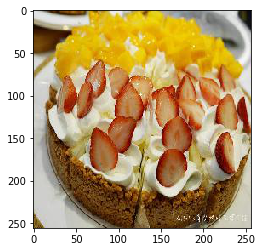

In [18]:
mask = np.zeros((256,256,3)).astype('uint8')
mask_list = generate_mask_list()
choose_mask = randint(0,9999)
x,y,w,h = mask_list[choose_mask]
print (x,y,w,h)
#mask[x:x+w,y:y+h,:]=255  


mask[x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]=255  # masked area = 1
plt.imshow(mask)

# save mask
cv2.imwrite(src+'mask'+str(img_no)+'.png', mask)
mask_path = src+'mask'+str(img_no)+'.png'


true_img_path =  src+str(img_no)+'.jpg'
true_img = cv2.imread(src+str(img_no)+'.jpg')
plt.imshow(cv2.cvtColor(true_img, cv2.COLOR_BGR2RGB))
#plt.show()


masked_img = true_img.copy()
masked_img[mask > 0] = 255
cv2.imwrite(src+'masked_img'+str(img_no)+'.jpg', masked_img)
masked_img_path = src+'masked_img'+str(img_no)+'.jpg'
output_img_path= src+'output'+str(img_no)+'.png'


# here should change ....too many times load model 
subprocess.call(f"python test.py --image {masked_img_path} --mask {mask_path} \
--output {output_img_path} --checkpoint_dir model_logs/release_imagenet_256 ", shell=True)

output_img =  cv2.imread(output_img_path)


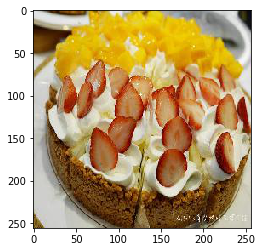

In [19]:
# show true image
plt.imshow(cv2.cvtColor(true_img, cv2.COLOR_BGR2RGB))

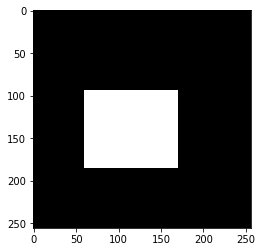

In [20]:
# show mask
plt.imshow(mask)

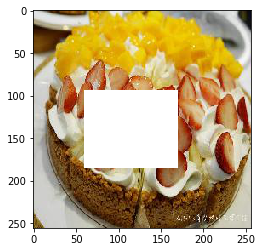

In [21]:
plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))

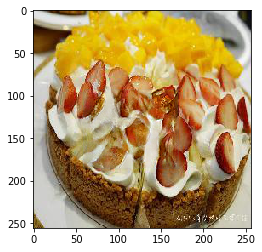

In [22]:
# show generated image
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))

In [23]:
generated_img_area = output_img[x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]/255.
print (generated_img_area.shape)
test = generated_img_area[:,:,0]
generated_img_area = generated_img_area[np.newaxis,:,:,:]

print (generated_img_area.shape)

(92, 110, 3)
(1, 92, 110, 3)


In [24]:
# load model and do inference 
size =1
ch=32

model = build_model(size,ch)


model.load_weights('4_layer_cnn_1_img_n_mask')

improved_area = model.predict ([generated_img_area]*2)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, None, None, 3 12          input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, None, None, 3 12          input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_21 

In [25]:

print (len(improved_area))
print (improved_area[-1].shape)
print (np.max(improved_area[-1]), np.min(improved_area[-1]))
improved_img = np.round(np.squeeze(improved_area[-1]*255.)).astype(int)
print (improved_img.dtype)
print (np.max(improved_img), np.min(improved_img))

print ('*\n',improved_img.shape)

true_img_area = true_img[x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:]


print ('\n')
print (improved_img[:,:,0])
print ('\n')

print (true_img_area[:,:,0])
print ('\n')
print (np.round(test*255.))


6
(1, 92, 110, 3)
1.0 0.0
int64
255 0
*
 (92, 110, 3)


[[ 96  54 151 ... 255 200 121]
 [161 164 118 ...  14 255  63]
 [174 126 137 ...   0  78 174]
 ...
 [177 252   1 ... 104 106  63]
 [187 137 179 ... 203  71 116]
 [168  46 110 ... 165  66 163]]


[[ 37  53  54 ... 143  54  31]
 [ 33  62  61 ... 114  21  10]
 [ 63  66  53 ...  74  22   0]
 ...
 [157 108 100 ...  56  59  60]
 [126  90  70 ...  57  56  57]
 [ 59  45  43 ...  50  55  65]]


[[49. 80. 62. ... 64. 57. 38.]
 [61. 69. 85. ... 31. 36. 43.]
 [83. 65. 81. ... 31. 78. 19.]
 ...
 [22. 28. 41. ... 69. 92. 79.]
 [29. 15.  7. ... 70. 81. 79.]
 [18.  8.  0. ... 62. 69. 81.]]


In [26]:
# replace masked area by Shape Free NN inference result
output_img2 =output_img.copy()
output_img2[x+128-int(w/2):x+128+int(w/2),y+128-int(h/2):y+128+int(h/2),:] = improved_img

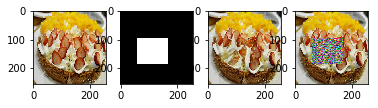

In [27]:
# show the final result 

f = plt.figure()
f.add_subplot(1,4, 1)
plt.imshow(cv2.cvtColor(true_img, cv2.COLOR_BGR2RGB))


f.add_subplot(1,4, 2)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

f.add_subplot(1,4, 3)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))


f.add_subplot(1,4, 4)
plt.imshow(cv2.cvtColor(output_img2, cv2.COLOR_BGR2RGB))

plt.show(block=True)
